In [12]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import os
import sys
from astropy.table import Table


In [13]:
# IMPORT Z SPACE DATA

rawdata_path = '../../../../Data/catalogs/Draco/simulated_data_thomas/'
configuration_path = rawdata_path+'params_proj_Draco_bg.ini'
rawdata_data = rawdata_path+'out_cat/out_test_DracoInDraco_mock_06052025_eDR3.fits'
rawdata = Table.read(rawdata_data).to_pandas()

print(rawdata.columns)

#CHECK HALF-LIGHT RADIUS
hl_radius = 0.16 #  0.36 Sextans           0.21 Sculptor          0.16 Draco

color = rawdata['BP0'] - rawdata['RP0']
rawdata['BP0-RP0'] = color

test_indices = np.where((rawdata['Xi'].values)**2. + (rawdata['Xn'].values)**2. <= (7*0.36)**2.)[0]
train_indices = np.where((rawdata['Xi'].values)**2. + (rawdata['Xn'].values)**2. > (7*0.36)**2.)[0]

main_columns = ['source_id', 'Xi', 'Xn', 'pmra', 'pmdec', 'BP0', 'RP0', 'BP0-RP0', 'G0_c', 'parallax']
X_test = rawdata.loc[test_indices, main_columns]

X_test.reset_index(drop=True, inplace=True)
X_test.head()

Index(['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'pmra', 'pmdec', 'phot_g_n_obs', 'phot_bp_n_obs',
       'phot_rp_n_obs', 'astrometric_matched_transits',
       'visibility_periods_used', 'ipd_gof_harmonic_amplitude',
       'phot_g_mean_mag_err', 'phot_bp_mean_mag_err', 'phot_rp_mean_mag_err',
       'parallax_error', 'pmra_error', 'pmdec_error', 'parallax',
       'ipd_frac_multi_peak', 'ruwe', 'bp_rp', 'phot_bp_rp_excess_factor',
       'pmra_pmdec_corr', 'astrometric_n_good_obs_al',
       'astrometric_params_solved', 'G0_c', 'BP0', 'RP0', 'Xi', 'Xn', 'Rad',
       'P'],
      dtype='object')


,source_id,Xi,Xn,pmra,pmdec,BP0,RP0,BP0-RP0,G0_c,parallax
0,42,-0.104545,-0.037411,-0.280926,-0.026032,18.954642,17.841331,1.113311,18.482388,-0.007211
1,42,0.081207,0.094799,0.140331,-0.263985,18.093508,16.957893,1.135616,17.604562,-0.006477
2,42,-0.045342,-0.057696,-0.134007,0.096449,19.467280,18.484274,0.983006,19.093861,0.022734
3,42,-0.102395,0.017652,0.369491,0.085948,20.109863,19.974854,0.135008,20.058642,-0.032379
4,42,0.015912,-0.053953,0.007621,-0.589486,19.400291,18.418246,0.982044,18.998001,-0.024948


In [14]:
# opening the params_proj.ini file
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the .ini file
config.read(configuration_path)

# Print all sections and their content
for section in config.sections():
    print(f"[{section}]")
    for key, value in config.items(section):
        print(f"{key} = {value}")
    print()

[Projection]
ra = 247.0
dec = 54.0
dm = 19.53
pmra = 0.04
pmdec = -0.19
vlos = -292.30
ell = 0.3
pa = 87.0
incl = 90.0
corrpmra_pmdec = 0.23



In [15]:
def mahalanobis_distance(df, raw_df):
    
    delta_mu = np.vstack((df['PMra'].values, df['PMdec'].values)).T 
    print(delta_mu.shape)
    
    # Covariance matrix from Gaia uncertainties and correlation
    errors_ra = raw_df['pmra_error'].values
    errors_dec = raw_df['pmdec_error'].values
    rho = raw_df['pmra_pmdec_corr'].values       #  # Assuming no correlation for simplicity in case of mock data

    # Build covariance matrices: shape (N, 2, 2)
    cov_00 = errors_ra**2
    cov_11 = errors_dec**2
    cov_01 = rho * errors_ra * errors_dec

    cov_matrices = np.zeros((len(df), 2, 2))
    cov_matrices[:, 0, 0] = cov_00
    cov_matrices[:, 1, 1] = cov_11
    cov_matrices[:, 0, 1] = cov_01
    cov_matrices[:, 1, 0] = cov_01

    # Invert each 2x2 covariance matrix using a closed formula
    det = cov_00 * cov_11 - cov_01**2
    inv_cov = np.zeros_like(cov_matrices)

    inv_cov[:, 0, 0] =  cov_11 / det
    inv_cov[:, 1, 1] =  cov_00 / det
    inv_cov[:, 0, 1] = -cov_01 / det
    inv_cov[:, 1, 0] = -cov_01 / det

    # Now compute Mahalanobis distances
    # For each star: sqrt(Δ.T @ Σ⁻¹ @ Δ)
    md_squared = np.einsum('ni,nij,nj->n', delta_mu, inv_cov, delta_mu)
    mahalanobis_dist = np.sqrt(md_squared)

    
    return mahalanobis_dist

In [16]:
members = np.where(X_test['source_id'] == 42)[0]
non_members = np.where(X_test['source_id'] != 42)[0]

# PARALAXES/ERRORS
Parax_err = X_test['parallax'].values / rawdata.loc[test_indices, 'parallax_error'].values
print(Parax_err.shape)
X_test['parax/err'] = Parax_err
X_test['parax_err'] = rawdata.loc[test_indices, 'parallax_error'].values

# PM over error:

pmra_sys = float(config['Projection']['pmra'])
pmdec_sys = float(config['Projection']['pmdec'])
PMra = X_test['pmra'] - pmra_sys
PMdec = X_test['pmdec'] - pmdec_sys

X_test['PMra'] = PMra
X_test['PMdec'] = PMdec

X_test['PMra/err'] = PMra / rawdata.loc[test_indices, 'pmra_error'].values    # using PM is when is corrected for systemic proper motion
X_test['PMdec/err'] = PMdec / rawdata.loc[test_indices, 'pmdec_error'].values

X_test['PMra_err'] = rawdata.loc[test_indices, 'pmra_error'].values
X_test['PMdec_err'] = rawdata.loc[test_indices, 'pmdec_error'].values

X_test['Xra_x_PMra'] = X_test['Xi'] * X_test['PMra']
X_test['Xdec_x_PMdec'] = X_test['Xn'] * X_test['PMdec']

X_test['mahalanobis_PM'] = mahalanobis_distance(X_test, rawdata.iloc[test_indices])
X_test['MembershipScore'] = X_test['mahalanobis_PM'] * np.sqrt(X_test['Xi']**2. + X_test['Xn']**2.)


## PM SNR
X_test['PM_SNR'] = np.sqrt(X_test['PMra']**2. + X_test['PMdec']**2.) / np.sqrt(X_test['PMra_err']**2. + X_test['PMdec_err']**2.)

print(X_test.head())
print(X_test.shape)

(18259,)
(18259, 2)
   source_id        Xi        Xn      pmra     pmdec        BP0        RP0  \
0         42 -0.104545 -0.037411 -0.280926 -0.026032  18.954642  17.841331   
1         42  0.081207  0.094799  0.140331 -0.263985  18.093508  16.957893   
2         42 -0.045342 -0.057696 -0.134007  0.096449  19.467280  18.484274   
3         42 -0.102395  0.017652  0.369491  0.085948  20.109863  19.974854   
4         42  0.015912 -0.053953  0.007621 -0.589486  19.400291  18.418246   

    BP0-RP0       G0_c  parallax  ...     PMdec  PMra/err  PMdec/err  \
0  1.113311  18.482388 -0.007211  ...  0.163968 -2.181421   0.998820   
1  1.135616  17.604562 -0.006477  ... -0.073985  1.079130  -0.714769   
2  0.983006  19.093861  0.022734  ...  0.286449 -0.809960   1.164633   
3  0.135008  20.058642 -0.032379  ...  0.275948  0.776792   0.590875   
4  0.982044  18.998001 -0.024948  ... -0.399486 -0.159033  -1.730072   

   PMra_err  PMdec_err  Xra_x_PMra  Xdec_x_PMdec  mahalanobis_PM  \
0  0.14711

In [17]:
X_test['mahalanobis_PM'].describe()

count    18259.000000
mean        10.132387
std         11.812648
min          0.007239
25%          3.360506
50%          6.627750
75%         12.502099
max        291.521708
Name: mahalanobis_PM, dtype: float64

array([[<Axes: title={'center': 'mahalanobis_PM'}>,
        <Axes: title={'center': 'MembershipScore'}>]], dtype=object)

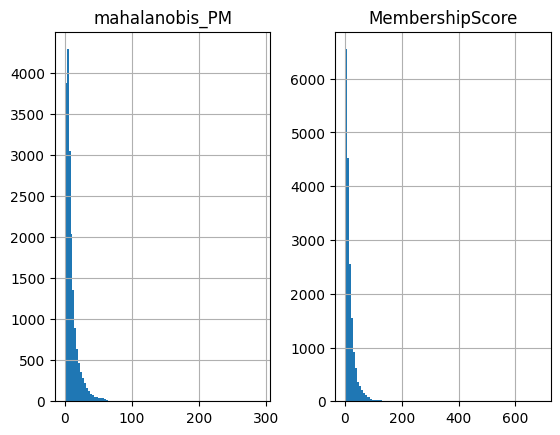

In [18]:
X_test[['mahalanobis_PM', 'MembershipScore']].hist(bins=100)

array([[<Axes: title={'center': 'mahalanobis_PM'}>,
        <Axes: title={'center': 'MembershipScore'}>]], dtype=object)

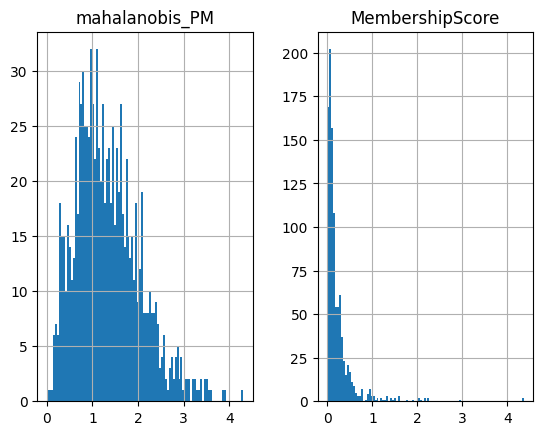

In [19]:
X_test.loc[members, ['mahalanobis_PM', 'MembershipScore']].hist(bins=100)

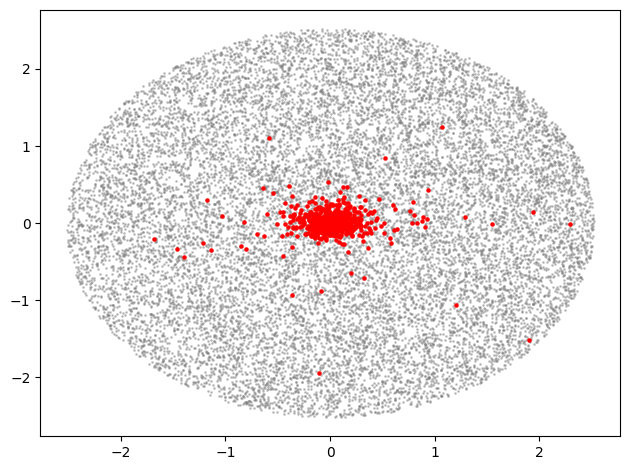

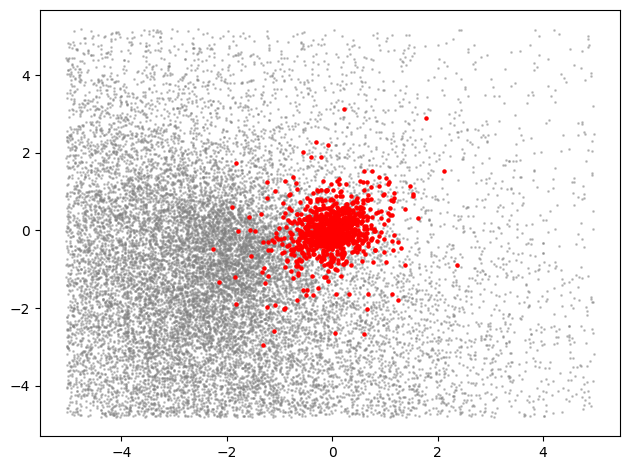

In [20]:
plt.scatter(X_test['Xi'], X_test['Xn'], s=1, c='gray', alpha=0.4)
plt.scatter(X_test.loc[members, 'Xi'], X_test.loc[members, 'Xn'], c='red', s=5)

plt.tight_layout()
plt.show()

plt.scatter(X_test['PMra'], X_test['PMdec'], s=1, c='gray', alpha=0.4)
plt.scatter(X_test.loc[members, 'PMra'], X_test.loc[members, 'PMdec'], c='red', s=5)

plt.tight_layout()
plt.show()

In [21]:
def confusion_plots(TP, FP, FN, TN, n_iteration=1):
    
    print('actual members: ', len(members))
    print('actual non-members: ', len(non_members))
    print('TP: ', len(TP))
    print('FP: ', len(FP))
    print('FN: ', len(FN))
    print('TN: ', len(TN))
  

    confusion_dict = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}
    confusion_type = ['TP', 'FP', 'FN', 'TN']

    fig, ax = plt.subplots(4, 4, figsize=(20, 20))
    fig.suptitle(f'Confusion plots: UMAP {n_iteration} iteration', fontsize=20)
    for i in range(4):
        ax[i, 0].scatter(X_test['BP0-RP0'], X_test['G0_c'], s=5, alpha=0.3, c='grey')
        ax[i, 0].scatter(X_test.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], X_test.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
        ax[i, 0].invert_yaxis()
        ax[i, 0].set_xlabel('BP0-RP0')
        ax[i, 0].set_ylabel('G0_c')
        ax[i, 0].set_title(f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])}')

        ax[i, 1].scatter(X_test['pmra'], X_test['pmdec'], s=5, alpha=0.3, c='grey')
        ax[i, 1].scatter(X_test.loc[confusion_dict[confusion_type[i]], ['pmra']], X_test.loc[confusion_dict[confusion_type[i]], ['pmdec']], s=10, c='red')
        ax[i, 1].set_xlabel('pmra')
        ax[i, 1].set_ylabel('pmdec')

        ax[i, 2].scatter(X_test['Xi'], X_test['Xn'], s=5, alpha=0.3, c='grey')
        ax[i, 2].scatter(X_test.loc[confusion_dict[confusion_type[i]], ['Xi']], X_test.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red')
        ax[i, 2].set_xlabel('Xi')
        ax[i, 2].set_ylabel('Xn')

        ax[i, 3].scatter(X_test['PMra/err'], X_test['PMdec/err'], s=5, alpha=0.3, c='grey')
        ax[i, 3].scatter(X_test.loc[confusion_dict[confusion_type[i]], ['PMra/err']], X_test.loc[confusion_dict[confusion_type[i]], ['PMdec/err']], s=10, c='red')
        ax[i, 3].set_xlabel('PMra/err')
        ax[i, 3].set_ylabel('PMdec/err')

    plt.tight_layout()
    plt.show()

    return fig


In [22]:
def confusion_plots_latex(df, TP, FP, FN, TN, memb_thr, nonmemb_thr):
    
    members = np.where(df['source_id'] == 42)[0]
    non_members = np.where(df['source_id'] != 42)[0]
    
    print('actual members: ', len(members))
    print('actual non-members: ', len(non_members))
    print('TP: ', len(TP))
    print('FP: ', len(FP))
    print('FN: ', len(FN))
    print('TN: ', len(TN))
  

    confusion_dict = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}
    confusion_type = ['TP', 'FP', 'FN', 'TN']

    fig, ax = plt.subplots(4, 3, figsize=(15, 20))
    #fig.suptitle(f'Confusion plots UMAP: thresholds {memb_thr} - {nonmemb_thr}; members={members.shape[0]} non members={non_members.shape[0]}', fontsize=20)
    for i in range(4):

        if confusion_type[i] == 'TP' or confusion_type[i] == 'FN':
            ax[i, 0].scatter(df['Xi'], df['Xn'], s=5, alpha=0.3, c='grey')
            ax[i, 0].scatter(df.loc[confusion_dict[confusion_type[i]], ['Xi']], df.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                             label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/len(members)*100:.2f}%')
            ax[i, 0].set_xlabel('Xi')
            ax[i, 0].set_ylabel('Xn')
            ax[i, 0].legend(loc='upper left')

            ax[i, 1].scatter(df['PMra'], df['PMdec'], s=5, alpha=0.3, c='grey')
            ax[i, 1].scatter(df.loc[confusion_dict[confusion_type[i]], ['PMra']], df.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
            ax[i, 1].set_xlabel('pmra')
            ax[i, 1].set_ylabel('pmdec')

            ax[i, 2].scatter(df['BP0-RP0'], df['G0_c'], s=5, alpha=0.3, c='grey')
            ax[i, 2].scatter(df.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], df.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
            ax[i, 2].invert_yaxis()
            ax[i, 2].set_xlabel('BP0-RP0')
            ax[i, 2].set_ylabel('G0_c')

        else:

            ax[i, 0].scatter(df['Xi'], df['Xn'], s=5, alpha=0.3, c='grey')
            ax[i, 0].scatter(df.loc[confusion_dict[confusion_type[i]], ['Xi']], df.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                             label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/len(non_members)*100:.2f}%')
            ax[i, 0].set_xlabel('Xi')
            ax[i, 0].set_ylabel('Xn')
            ax[i, 0].legend(loc='upper left')

            ax[i, 1].scatter(df['PMra'], df['PMdec'], s=5, alpha=0.3, c='grey')
            ax[i, 1].scatter(df.loc[confusion_dict[confusion_type[i]], ['PMra']], df.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
            ax[i, 1].set_xlabel('pmra')
            ax[i, 1].set_ylabel('pmdec')

            ax[i, 2].scatter(df['BP0-RP0'], df['G0_c'], s=5, alpha=0.3, c='grey')
            ax[i, 2].scatter(df.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], df.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
            ax[i, 2].invert_yaxis()
            ax[i, 2].set_xlabel('BP0-RP0')
            ax[i, 2].set_ylabel('G0_c')

    #plt.tight_layout()
    plt.show()

    return fig


In [23]:
features  = ['Xi', 'Xn', 'PMra', 'PMdec', 'PMra_err', 'PMdec_err', 'BP0-RP0', 'G0_c', 'parax/err']
features2 = ['Xi', 'Xn', 'PMra', 'PMdec', 'PMra/err', 'PMdec/err', 'BP0-RP0', 'G0_c', 'parax/err']
features3 = ['Xi', 'Xn', 'PMra', 'PMdec', 'PMra/err', 'PMdec/err', 'PM_SNR', 'BP0-RP0', 'G0_c', 'parax/err']
features4 = ['Xi', 'Xn', 'PMra', 'PMdec', 'PMra_err', 'PMdec_err', 'PM_SNR', 'BP0-RP0', 'G0_c', 'parax/err']

#features6 = ['MembershipScore', 'PMra', 'PMdec', 'PMra/err', 'PMdec/err', 'mahalanobis_PM', 'BP0-RP0', 'G0_c', 'parax/err']

### UMAP

In [24]:
import umap
from sklearn.preprocessing import MinMaxScaler

def single_umap(X_test, features):

    PCA = X_test[['source_id'] + features].copy()
    print(PCA.head())
    #PCA.hist(figsize=(20, 20), bins=50)

    ## SCALING
    scaler = MinMaxScaler()
    PCA[features] = scaler.fit_transform(X_test[features])

    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=50, min_dist=0.0)   # default was n_neighbors=15, min_dist=0.1
    z_umap = umap_reducer.fit_transform(PCA[features])




    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].scatter(z_umap[members, 0], z_umap[members, 1], s=10, alpha=0.4, label='members', color='tab:orange')
    ax[0].scatter(z_umap[non_members, 0], z_umap[non_members, 1], s=10, alpha=0.4, label='non members', color='tab:blue')
    ax[0].set_xlabel(r'$z_1$')
    ax[0].set_ylabel(r'$z_2$')
    #ax[0].set_title('UMAP of PMs')
    ax[0].legend()

    ax[1].scatter(z_umap[members, 0], z_umap[members, 1], s=10, color='tab:orange')
    ax[1].set_xlabel(r'$z_1$')
    ax[1].set_ylabel(r'$z_2$')
    #ax[1].set_title('UMAP of PMs')

    ax[2].scatter(z_umap[non_members, 0], z_umap[non_members, 1], s=10, color='tab:blue')
    ax[2].set_xlabel(r'$z_1$')
    ax[2].set_ylabel(r'$z_2$')
    #ax[2].set_title('UMAP of PMs')

    plt.tight_layout()
    plt.show()

    #if save:
        #plt.savefig(saveplots_dir+'UMAP_single.png', dpi=300, bbox_inches='tight')

    return z_umap



In [25]:
#z_umap6 = single_umap(X_test, features6)

   source_id        Xi        Xn      PMra     PMdec  PMra_err  PMdec_err  \
0         42 -0.104545 -0.037411 -0.320926  0.163968  0.147118   0.164161   
1         42  0.081207  0.094799  0.100331 -0.073985  0.092974   0.103509   
2         42 -0.045342 -0.057696 -0.174007  0.286449  0.214834   0.245956   
3         42 -0.102395  0.017652  0.329491  0.275948  0.424169   0.467016   
4         42  0.015912 -0.053953 -0.032379 -0.399486  0.203597   0.230907   

    BP0-RP0       G0_c  parax/err  
0  1.113311  18.482388  -0.058805  
1  1.135616  17.604562  -0.083243  
2  0.983006  19.093861   0.124285  
3  0.135008  20.058642  -0.090331  
4  0.982044  18.998001  -0.143695  


c:\Users\bosca\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


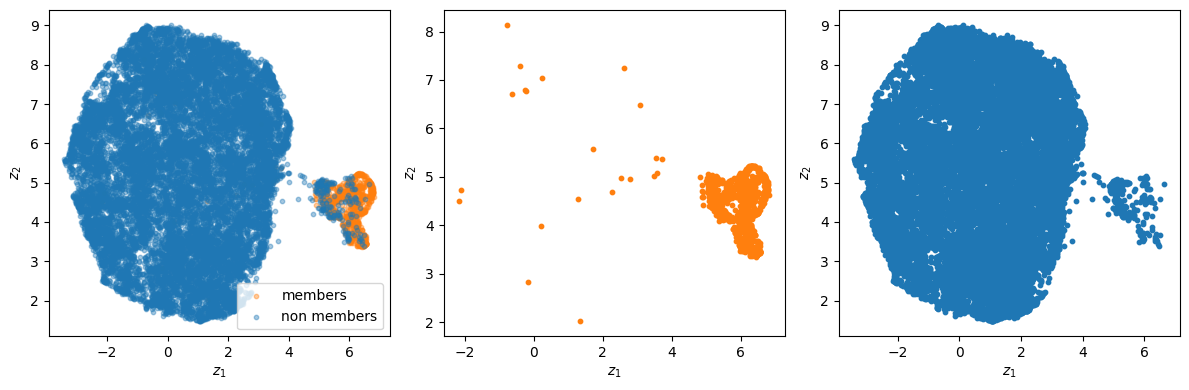

   source_id        Xi        Xn      PMra     PMdec  PMra/err  PMdec/err  \
0         42 -0.104545 -0.037411 -0.320926  0.163968 -2.181421   0.998820   
1         42  0.081207  0.094799  0.100331 -0.073985  1.079130  -0.714769   
2         42 -0.045342 -0.057696 -0.174007  0.286449 -0.809960   1.164633   
3         42 -0.102395  0.017652  0.329491  0.275948  0.776792   0.590875   
4         42  0.015912 -0.053953 -0.032379 -0.399486 -0.159033  -1.730072   

    BP0-RP0       G0_c  parax/err  
0  1.113311  18.482388  -0.058805  
1  1.135616  17.604562  -0.083243  
2  0.983006  19.093861   0.124285  
3  0.135008  20.058642  -0.090331  
4  0.982044  18.998001  -0.143695  


c:\Users\bosca\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


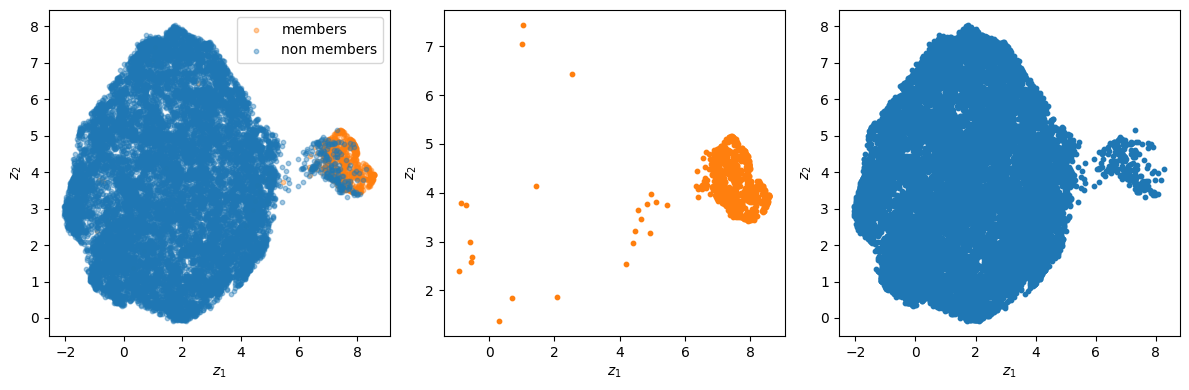

In [26]:
z_umap = single_umap(X_test, features)
z_umap2 = single_umap(X_test, features2)
#z_umap3 = single_umap(X_test, features3)
#z_umap4 = single_umap(X_test, features4)

In [27]:
print(z_umap.shape)
print(z_umap2.shape)
#print(z_umap3.shape)
#print(z_umap4.shape)

(18259, 2)
(18259, 2)


In [28]:
from scipy.cluster.hierarchy import linkage, fcluster

def clustering_single_umap(Z_umap, selecte_method):
    Z = linkage(Z_umap, method=selecte_method)

    # Cut the tree into two clusters, ensuring one has about 10 points
    labels = fcluster(Z, t=2, criterion='maxclust')

    # Count points per cluster
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    print("Cluster sizes:", cluster_sizes)

    cluster_1_indices = np.where(labels == 1)[0]  # Indices of cluster 1
    cluster_2_indices = np.where(labels == 2)[0]  # Indices of cluster 2

    print('if this larger, this cluster 1 is the contaminants: ',len(cluster_1_indices))
    print('if this larger, this cluster 2 is the contaminants: ',len(cluster_2_indices))
    print('otherwise, is the opposite')

    # Plot the results
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(Z_umap[cluster_1_indices, 0], Z_umap[cluster_1_indices, 1], c='blue', s=10, label='Cluster 1')
    plt.scatter(Z_umap[cluster_2_indices, 0], Z_umap[cluster_2_indices, 1], c='red', s=10, label='Cluster 2')
    plt.xlabel(r"$z_1$")
    plt.ylabel(r"$z_1$")
    plt.title("Hierarchical Clustering")
    plt.legend()
    plt.show()

In [29]:
from sklearn.cluster import AgglomerativeClustering

def alternative_clustering(Z_umap, selecte_method):
    model = AgglomerativeClustering(n_clusters=2, linkage=selecte_method)
    labels = model.fit_predict(Z_umap)

    # Count points per cluster
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    print("Cluster sizes:", cluster_sizes)

    cluster_1_indices = np.where(labels == 0)[0]  # Indices of cluster 0
    cluster_2_indices = np.where(labels == 1)[0]  # Indices of cluster 1

    print('if this larger, this cluster 1 is the contaminants: ',len(cluster_1_indices))
    print('if this larger, this cluster 2 is the contaminants: ',len(cluster_2_indices))
    print('otherwise, is the opposite')

    # Plot the results
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(Z_umap[cluster_1_indices, 0], Z_umap[cluster_1_indices, 1], c='blue', s=10, label='Cluster 1')
    plt.scatter(Z_umap[cluster_2_indices, 0], Z_umap[cluster_2_indices, 1], c='red', s=10, label='Cluster 2')
    plt.xlabel(r"$z_1$")
    plt.ylabel(r"$z_1$")
    plt.title("Agglomerative Clustering")
    plt.legend()
    plt.show()

Cluster sizes: {1: 9580, 2: 8679}
if this larger, this cluster 1 is the contaminants:  9580
if this larger, this cluster 2 is the contaminants:  8679
otherwise, is the opposite


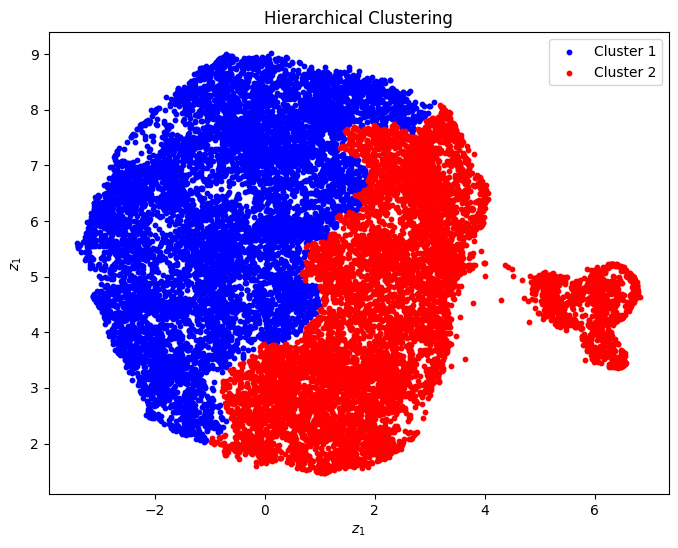

Cluster sizes: {1: 8868, 2: 9391}
if this larger, this cluster 1 is the contaminants:  8868
if this larger, this cluster 2 is the contaminants:  9391
otherwise, is the opposite


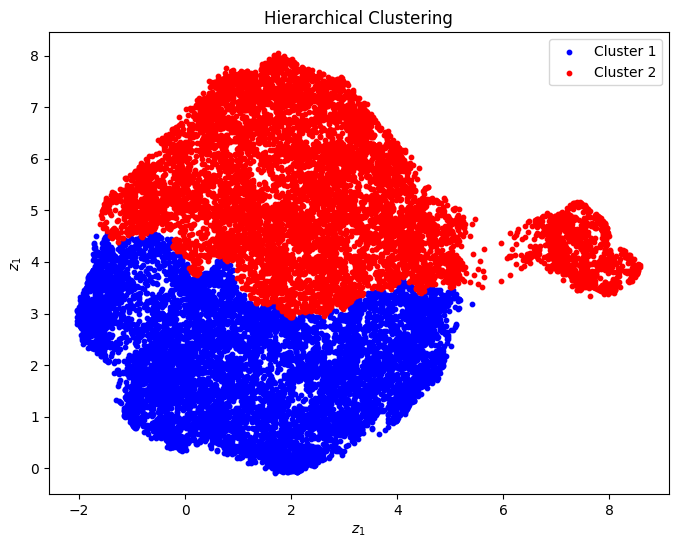

In [30]:
clustering_single_umap(z_umap, 'ward')
clustering_single_umap(z_umap2, 'ward')
#clustering_single_umap(z_umap3, 'ward')
#clustering_single_umap(z_umap4, 'ward')

#alternative_clustering(z_umap, 'ward')
#alternative_clustering(z_umap2, 'ward')
#alternative_clustering(z_umap3, 'ward')
#alternative_clustering(z_umap4, 'ward')

Cluster sizes: {1: 1169, 2: 17090}
if this larger, this cluster 1 is the contaminants:  1169
if this larger, this cluster 2 is the contaminants:  17090
otherwise, is the opposite


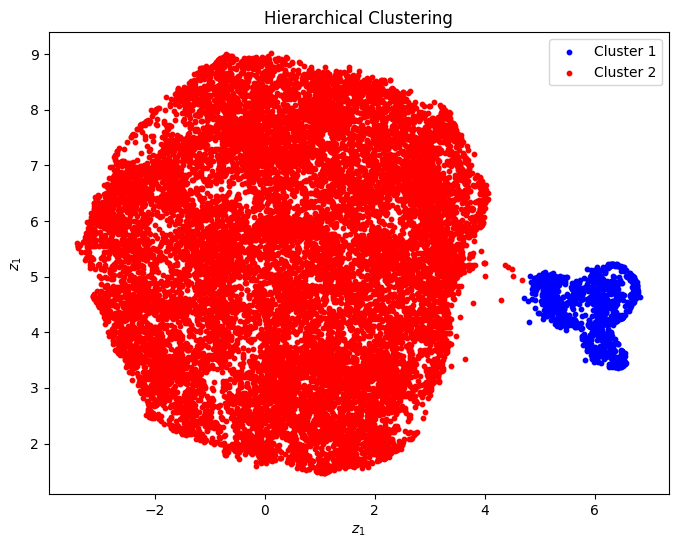

Cluster sizes: {1: 1225, 2: 17034}
if this larger, this cluster 1 is the contaminants:  1225
if this larger, this cluster 2 is the contaminants:  17034
otherwise, is the opposite


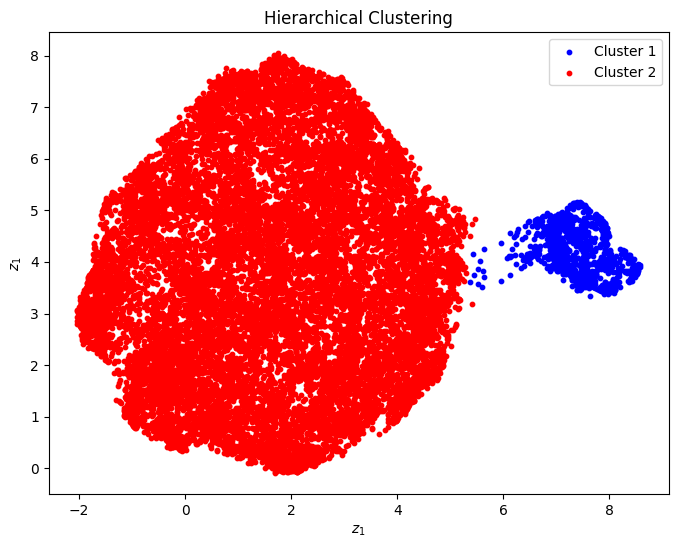

In [31]:
clustering_single_umap(z_umap, 'average')
clustering_single_umap(z_umap2, 'average')
#clustering_single_umap(z_umap3, 'average')
#clustering_single_umap(z_umap4, 'average')